In [2]:
import tensorflow as tf
import os

### Télécharge un fichier à partir d'une URL

In [3]:
URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

In [4]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [5]:
train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

In [6]:
tf.keras.preprocessing.image_dataset_from_directory

<function keras.utils.image_dataset.image_dataset_from_directory(directory, labels='inferred', label_mode='int', class_names=None, color_mode='rgb', batch_size=32, image_size=(256, 256), shuffle=True, seed=None, validation_split=None, subset=None, interpolation='bilinear', follow_links=False, crop_to_aspect_ratio=False, **kwargs)>

In [7]:
BATCH_SIZE = 32
IMG_SIZE = (160, 160)
train_dataset = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

Found 2000 files belonging to 2 classes.


In [8]:
validation_dataset = image_dataset_from_directory(validation_dir,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

Found 1000 files belonging to 2 classes.


### Créer un ensemble de dates de test

##### L'ensemble de données d'origine ne contient pas d'ensemble de test, nous devons donc créer. Pour ce faire, déterminez le nombre de lots de données disponibles dans l'ensemble de validation à l'aide de tf.data.experimental.cardiality, puis déplacez 20 % d'entre eux vers un ensemble de test.

##### take(count) : crée un ensemble de données avec au plus count éléments de cet ensemble de d

In [9]:
dataset = tf.data.Dataset.range(10)
dataset = dataset.take(3)
list(dataset.as_numpy_iterator())

[0, 1, 2]

##### skip(count) : crée un ensemble de données qui ignore les éléments de comptage de cet ensemble de données.

In [10]:
dataset = tf.data.Dataset.range(10)
dataset = dataset.skip(7)
list(dataset.as_numpy_iterator())

[7, 8, 9]

In [11]:
valdation_batches = tf.data.experimental.cardinality(validation_dataset)
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
test_batches = valdation_batches // 5
test_dataset = validation_dataset.take(test_batches)
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))
validation_dataset = validation_dataset.skip(test_batches)
print('Number of validation_dataset: %d' % tf.data.experimental.cardinality(validation_dataset))

Number of validation batches: 32
Number of test batches: 6
Number of validation_dataset: 26


### Afficher le nom de la classe de l'ensemble de données d'entraînement

In [12]:
class_names = train_dataset.class_names
class_names

['cats', 'dogs']

### Visualiser l'ensemble de données d'entraînement

In [13]:
import numpy as np
import matplotlib.pyplot as plt

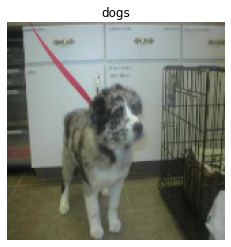

In [14]:
for image, label in train_dataset.take(1):
    image = image.numpy().astype("uint8")
    plt.imshow(image[0])
    plt.title(class_names[label[0]])
    plt.axis('off')
    plt.show()

### Afficher 15 images de données d'entraînement

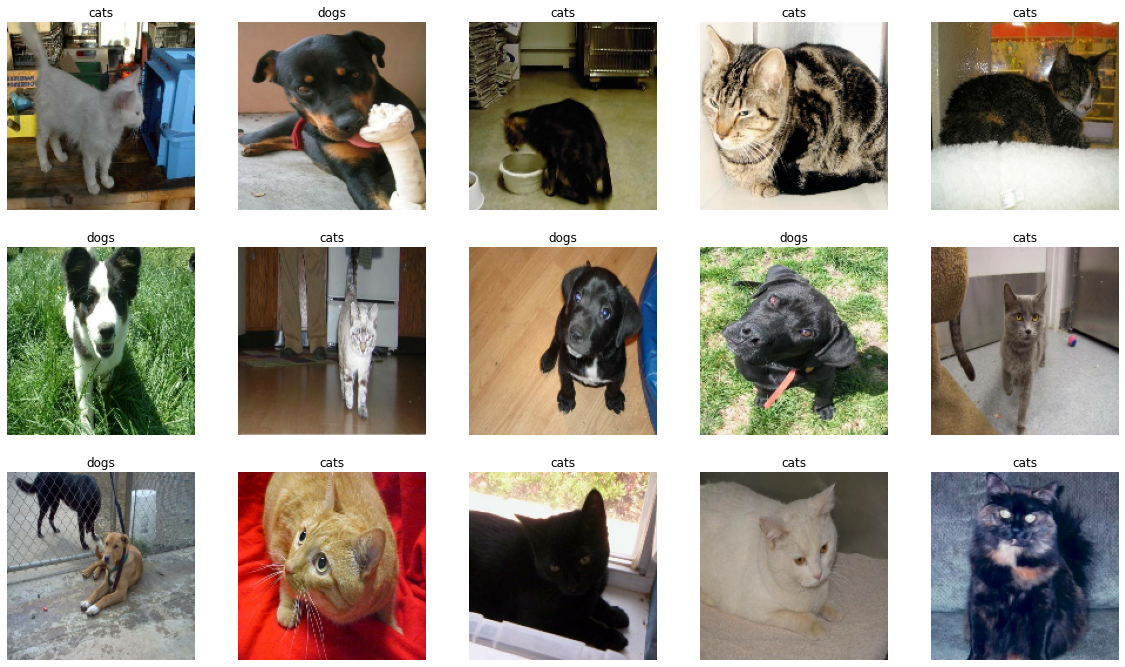

In [15]:
plt.figure(figsize=(20, 20))
for images, labels in train_dataset.take(1):
    for i in range(15):
        ax = plt.subplot(5, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

### Configurer l'ensemble de données pour les performances

##### Utilisez la prélecture tamponnée pour charger des images à partir du disque sans que les E/S ne deviennent bloquantes.

In [16]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

### Tracer une image augmentée

In [17]:
data_augmentation = tf.keras.Sequential([
tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

first image shape: (160, 160, 3)
Expaned dims of first image:   (1, 160, 160, 3)


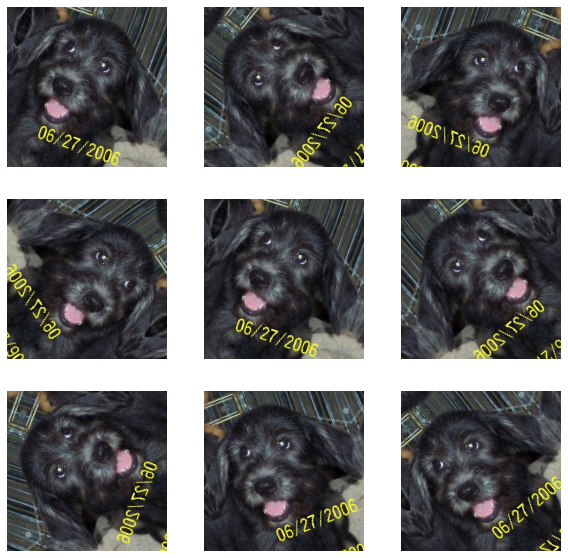

In [18]:
plt.figure(figsize=(10, 10))
for image, label in train_dataset.take(1):
    first_image = image[0]
    print(f'first image shape: {first_image.shape}')
    expaned_dims_first_image =  tf.expand_dims(first_image, 0)
    print(f'Expaned dims of first image:   {expaned_dims_first_image.shape}')
    
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        
        augmented_image=data_augmentation(expaned_dims_first_image)
        
        #rescale augmented_image
        augmented_image = augmented_image[0] / 255
        plt.imshow(augmented_image)
        plt.axis('off')

### Redimensionner les valeurs des pixels

###### Dans cet exemple, nous allons utiliser le modèle de base du modèle MobileNet V2 développé chez Google. Ce modèle attend des valeurs de pixels dans [-1,1], mais actuellement les valeurs de pixels dans nos images sont dans [0–255]. Pour les redimensionner, utilisez la méthode de prétraitement incluse avec le modèle. Alors redimensionnons-les.

###### tf.keras.applications.mobilenet_v2.preprocess_input : Prétraite un tenseur ou un tableau Numpy encodant un lot d'images. Renvoie : les valeurs de pixels d'entrée sont mises à l'échelle entre -1 et 1, par échantillon.

###### tf.keras.layers.experimental.preprocessing.Rescaling(scale, offset=0.0, **kwargs) : multipliez les entrées par l'échelle et ajoutez un décalage.

###### Par exemple :

###### Pour remettre à l'échelle une entrée dans la plage [0, 255] pour qu'elle soit dans la plage [0, 1], vous devez passer scale=1./255.

###### Pour remettre à l'échelle une entrée dans la plage [0, 255] pour qu'elle soit dans la plage [-1, 1], vous devez passer scale=1./127.5, offset=-1.

###### Nous pouvons utiliser l'un d'eux pour redimensionner les images. Nous utilisons la première option pour redimensionner.

In [19]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
preprocess_input

<function keras.applications.mobilenet_v2.preprocess_input(x, data_format=None)>

### Créer le modèle de base à partir du modèle pré-entraîné MobileNet V2

##### Créons un modèle de base à partir du modèle MobileNet V2. Ceci est pré-entraîné sur l'ensemble de données ImageNet, un grand ensemble de données composé de 1,4 million d'images et de 1000 classes.

##### Lorsque vous travaillez avec un petit jeu de données, il est courant de tirer parti des fonctionnalités apprises par un modèle formé sur un plus grand jeu de données dans le même domaine. Cela se fait en instanciant le modèle pré-entraîné et en ajoutant un classificateur entièrement connecté au-dessus. Le modèle pré-entraîné est « figé » et seuls les poids du classificateur sont mis à jour pendant l'entraînement.

In [20]:
IMG_SIZE

IMG_SHAPE = IMG_SIZE + (3,)
IMG_SHAPE

(160, 160, 3)

In [21]:
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [22]:
base_model

###### Cet extracteur de fonctionnalités convertit chaque image 160x160x3 en un bloc de fonctionnalités 5x5x1280.

In [23]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


### Geler la base convolutive
###### Il est important de geler la base convolutive avant de compiler et d'entraîner le modèle. Le gel (en définissant layer.trainable = False) empêche la mise à jour des poids dans une couche donnée pendant l'entraînement. MobileNet V2 a de nombreuses couches, donc la définition de l'indicateur d'apprentissage du modèle entier sur False les gèlera toutes.

In [24]:
base_model.trainable = False

In [25]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

### Ajouter une tête de classement

##### Pour générer des prédictions à partir du bloc d'entités, faites la moyenne sur les emplacements spatiaux 5x5, en utilisant une couche tf.keras.layers.GlobalAveragePooling2D pour convertir les caractéristiques en un seul vecteur de 1280 éléments par image.

In [26]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


### Appliquer une couche dense sur feature_batch_average

##### Appliquez une couche tf.keras.layers.Dense pour convertir ces caractéristiques en une seule prédiction par image. Nous n'avons pas besoin d'une fonction d'activation ici car cette prédiction sera traitée comme un logit ou une valeur de prédiction brute. Les nombres positifs prédisent la classe 1, les nombres négatifs prédisent la classe 0.

In [27]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


### Construire un modèle

In [28]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)
model

### Compiler le modèle

##### Dans notre base de données, il existe deux classes, nous utiliserons une perte d'entropie croisée binaire avec from_logits=True puisque le modèle fournit une sortie linéaire.

In [29]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate), loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [30]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

###### Les 2,5 millions de paramètres dans MobileNet sont gelés, mais il y a 1,2K de paramètres pouvant être entraînés dans la couche dense.

### Afficher les variables d'entraînement du modèle

In [31]:
len(model.trainable_variables)

2

### Afficher la perte initiale et la précision sur l'ensemble de données de validation

In [32]:
loss0, accuracy0 = model.evaluate(validation_dataset)

26/26 [==============================] - 9s 294ms/step - loss: 0.5829 - accuracy: 0.7129


In [33]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.58
initial accuracy: 0.71


### Former le modèle

In [34]:
EPOCHS = 10
history = model.fit(train_dataset,
                    epochs=EPOCHS,
                    validation_data=validation_dataset)

Epoch 1/10
63/63 [==============================] - 34s 488ms/step - loss: 0.3267 - accuracy: 0.8380 - val_loss: 0.1065 - val_accuracy: 0.9629
Epoch 2/10
63/63 [==============================] - 31s 496ms/step - loss: 0.1918 - accuracy: 0.9080 - val_loss: 0.0803 - val_accuracy: 0.9728
Epoch 3/10
63/63 [==============================] - 31s 499ms/step - loss: 0.1427 - accuracy: 0.9330 - val_loss: 0.0656 - val_accuracy: 0.9765
Epoch 4/10
63/63 [==============================] - 31s 497ms/step - loss: 0.1335 - accuracy: 0.9425 - val_loss: 0.0666 - val_accuracy: 0.9752
Epoch 5/10
63/63 [==============================] - 32s 501ms/step - loss: 0.1252 - accuracy: 0.9485 - val_loss: 0.0554 - val_accuracy: 0.9802
Epoch 6/10
63/63 [==============================] - 31s 494ms/step - loss: 0.1169 - accuracy: 0.9500 - val_loss: 0.0583 - val_accuracy: 0.9790
Epoch 7/10
63/63 [==============================] - 31s 496ms/step - loss: 0.1270 - accuracy: 0.9445 - val_loss: 0.0541 - val_accuracy: 0.9802

### Précision/perte de validation du tracé

In [38]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

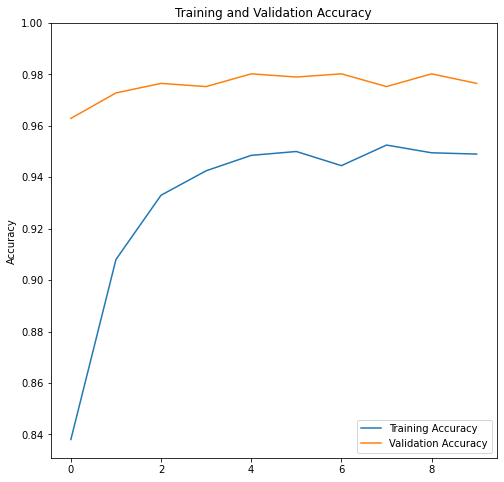

In [39]:
plt.figure(figsize=(8, 8))
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')
plt.show()

#### Tracer la formation et la perte de validation

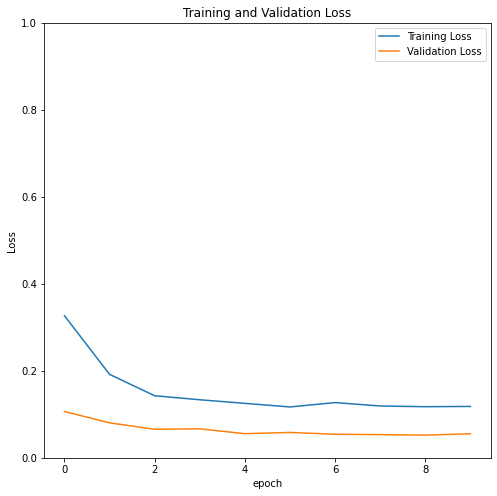

In [40]:
plt.figure(figsize=(8, 8))
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Loss')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Évaluation du modèle l'ensemble de données de test

In [41]:
loss, accuracy = model.evaluate(test_dataset)

6/6 [==============================] - 2s 342ms/step - loss: 0.0583 - accuracy: 0.9792


In [42]:
print('Test loss :', loss)
print('Test accuracy :', accuracy)

Test loss : 0.05831151083111763
Test accuracy : 0.9791666865348816


### Prédire l'ensemble de données de test

In [43]:
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()
print(predictions)

[ -8.276306    -6.936032     5.7436523    7.0771985   -5.8606157
   6.391616    -7.3928404    8.9862175   -2.4294345    3.897794
   3.5909247    7.192724     4.67496      5.380699    -9.5043545
   4.6698837   -8.400299     6.4402294   -7.9729643   -9.633958
   5.6347785   -3.7016733   -7.490146    -6.6681967  -11.196669
   2.744331    -6.1823807   -9.595827     0.54276276   5.733551
 -10.386835     1.1569015 ]


##### Le modèle nous donnera deux scores pour chaque image d'entrée. Logits correspond aux scores finaux non normalisés de votre modèle. Vous lui appliquez softmax pour obtenir une distribution de probabilité sur vos classes.

In [44]:
# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)
print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

Predictions:
 [0 0 1 1 0 1 0 1 0 1 1 1 1 1 0 1 0 1 0 0 1 0 0 0 0 1 0 0 1 1 0 1]
Labels:
 [0 0 1 1 0 1 0 1 0 1 1 1 1 1 0 1 0 1 0 0 1 0 0 0 0 1 0 0 1 1 0 1]


### Tracer la prédiction

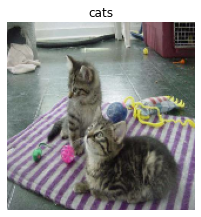

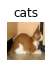

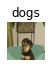

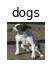

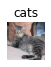

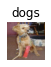

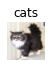

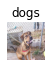

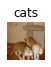

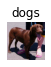

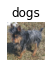

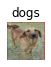

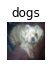

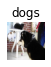

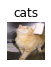

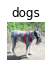

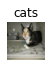

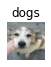

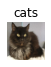

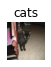

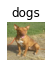

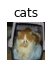

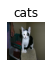

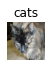

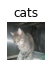

In [60]:
plt.figure(figsize=(20, 20))
for i in range(25):
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    plt.title(class_names[predictions[i]])
    plt.axis("off")
    plt.show()